# 4 bins

Note that before running each section, the kernel must be restarted.

In [1]:
%cd ../data/4_bins/4bins

C:\Users\liuzo\01 机器学习 物理\github\data\4_bins\4bins


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

In [3]:
max_min = lambda x: (x-x.min())/(x.max()-x.min())
cwd = os.getcwd()
# Read data and scale it by its maximum and minimum.
def prepare_data():    
    X = []
    Y = []
    for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)],[str(0)])):        
        path = os.path.join(cwd, ''.join(i))        
        names = os.listdir(path)       
        
        for name in names:            
            X.append(pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
            Y.append(np.array(eval('[' + ','.join(i) + ']')))            
        
    return np.array(X), np.array(Y)

In [4]:
X, Y = prepare_data()

In [5]:
# Split data into test set and the rest set, the size of test set is 20% of total data set
# The test set and the rest set are shuffled randomly.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((329, 1000, 1), (83, 1000, 1), (329, 4), (83, 4))

In [6]:
X_train_d = np.zeros((X_train.shape[0]*2, X_train.shape[1],  X_train.shape[2]))
y_train_d = np.zeros((y_train.shape[0]*2, y_train.shape[1]))
# Here the white noise is added to increase the robustness of the model and increase the size of the training set, 
# which is quantifyed by its standard deviation "scale".
# If scale = 0, there is no white noise.
# After the additional noise is added, the training set is re-scaled by its maximum and minimum.

for id  in range(X_train.shape[0]):
    X_train_d[id] = X_train[id]
    y_train_d[id] = y_train[id]
    X_train_d[id + X_train.shape[0]] = max_min(X_train[id] + np.random.normal(loc=0, scale=0.1, size = (X_train.shape[1], X_train.shape[2])))
    y_train_d[id + X_train.shape[0]] = y_train[id]

X_train = X_train_d
y_train = y_train_d
del X_train_d
del y_train_d

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((658, 1000, 1), (83, 1000, 1), (658, 4), (83, 4))

In [8]:
from keras import models
from keras import layers
from keras.optimizers import RMSprop
import numpy as np
seed = 7
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

Using TensorFlow backend.


In [9]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [10]:
# Deep learning model layers
def bulid_model_CNN():  
    
    model_list = []   
    
    cnn_out_1 = 20 #16
    cnn_len_1 = 460 #20
    
    model_list.append(
            layers.Conv1D(cnn_out_1, cnn_len_1, input_shape=(X_train.shape[1],1)),
            ) 
    model_list.append(layers.BatchNormalization())
    model_list.append(layers.Activation('relu'))
    model_list.append(layers.MaxPooling1D(3))    
   
    rnn_out = 16  
    lr_rate = 1e-3
    
    
    model_list.append(layers.Bidirectional(layers.LSTM(units=rnn_out, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model_list.append(layers.BatchNormalization())
    
    model_list.append(layers.Dense(y_train.shape[1], activation='sigmoid'))
    model = models.Sequential(model_list)   
    
    
    opt = RMSprop(lr=lr_rate)
    model.compile(optimizer=opt, loss='mse')
   
    return model

In [11]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [12]:
%cd ../weights

C:\Users\liuzo\01 机器学习 物理\github\data\4_bins\weights


In [13]:
# These callback function to schedule the learning rate and save weights of the model during training.
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

callbacks_list = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10), 
                   ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')  ]

In [14]:
%%time
k = 4  # k-fold cross validation
num_val_samples = X_train.shape[0] //k
num_epochs = 75
all_scores = []
all_scores_history = []
train_loss_history_list = []

for i in range(k):
    print('processing fold #', i)
    K.clear_session()  # clear previous wieghts to avoid cross-talk
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)              
    model = bulid_model_CNN()

    history = model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=64, verbose=0, validation_data=(val_data, val_targets),
                        callbacks=callbacks_list)
        
    # Evaluate the model on the validation data
    mae_history = history.history['val_loss']
    train_loss_history = history.history['loss']    

    all_scores_history.append(mae_history)
    train_loss_history_list.append(train_loss_history)        

processing fold # 0

Epoch 00001: saving model to weights-improvement-01-0.19.hdf5

Epoch 00002: saving model to weights-improvement-02-0.18.hdf5

Epoch 00003: saving model to weights-improvement-03-0.17.hdf5

Epoch 00004: saving model to weights-improvement-04-0.15.hdf5

Epoch 00005: saving model to weights-improvement-05-0.13.hdf5

Epoch 00006: saving model to weights-improvement-06-0.13.hdf5

Epoch 00007: saving model to weights-improvement-07-0.11.hdf5

Epoch 00008: saving model to weights-improvement-08-0.10.hdf5

Epoch 00009: saving model to weights-improvement-09-0.07.hdf5

Epoch 00010: saving model to weights-improvement-10-0.07.hdf5

Epoch 00011: saving model to weights-improvement-11-0.06.hdf5

Epoch 00012: saving model to weights-improvement-12-0.05.hdf5

Epoch 00013: saving model to weights-improvement-13-0.05.hdf5

Epoch 00014: saving model to weights-improvement-14-0.04.hdf5

Epoch 00015: saving model to weights-improvement-15-0.03.hdf5

Epoch 00016: saving model to weigh


Epoch 00056: saving model to weights-improvement-56-0.00.hdf5

Epoch 00057: saving model to weights-improvement-57-0.00.hdf5

Epoch 00058: saving model to weights-improvement-58-0.00.hdf5

Epoch 00059: saving model to weights-improvement-59-0.00.hdf5

Epoch 00060: saving model to weights-improvement-60-0.00.hdf5

Epoch 00061: saving model to weights-improvement-61-0.00.hdf5

Epoch 00062: saving model to weights-improvement-62-0.00.hdf5

Epoch 00063: saving model to weights-improvement-63-0.00.hdf5

Epoch 00064: saving model to weights-improvement-64-0.00.hdf5

Epoch 00065: saving model to weights-improvement-65-0.00.hdf5

Epoch 00066: saving model to weights-improvement-66-0.00.hdf5

Epoch 00067: saving model to weights-improvement-67-0.00.hdf5

Epoch 00068: saving model to weights-improvement-68-0.00.hdf5

Epoch 00069: saving model to weights-improvement-69-0.00.hdf5

Epoch 00070: saving model to weights-improvement-70-0.00.hdf5

Epoch 00071: saving model to weights-improvement-71-0.


Epoch 00036: saving model to weights-improvement-36-0.00.hdf5

Epoch 00037: saving model to weights-improvement-37-0.03.hdf5

Epoch 00038: saving model to weights-improvement-38-0.00.hdf5

Epoch 00039: saving model to weights-improvement-39-0.00.hdf5

Epoch 00040: saving model to weights-improvement-40-0.00.hdf5

Epoch 00041: saving model to weights-improvement-41-0.02.hdf5

Epoch 00042: saving model to weights-improvement-42-0.03.hdf5

Epoch 00043: saving model to weights-improvement-43-0.01.hdf5

Epoch 00044: saving model to weights-improvement-44-0.00.hdf5

Epoch 00045: saving model to weights-improvement-45-0.00.hdf5

Epoch 00046: saving model to weights-improvement-46-0.00.hdf5

Epoch 00047: saving model to weights-improvement-47-0.00.hdf5

Epoch 00048: saving model to weights-improvement-48-0.00.hdf5

Epoch 00049: saving model to weights-improvement-49-0.01.hdf5

Epoch 00050: saving model to weights-improvement-50-0.00.hdf5

Epoch 00051: saving model to weights-improvement-51-0.

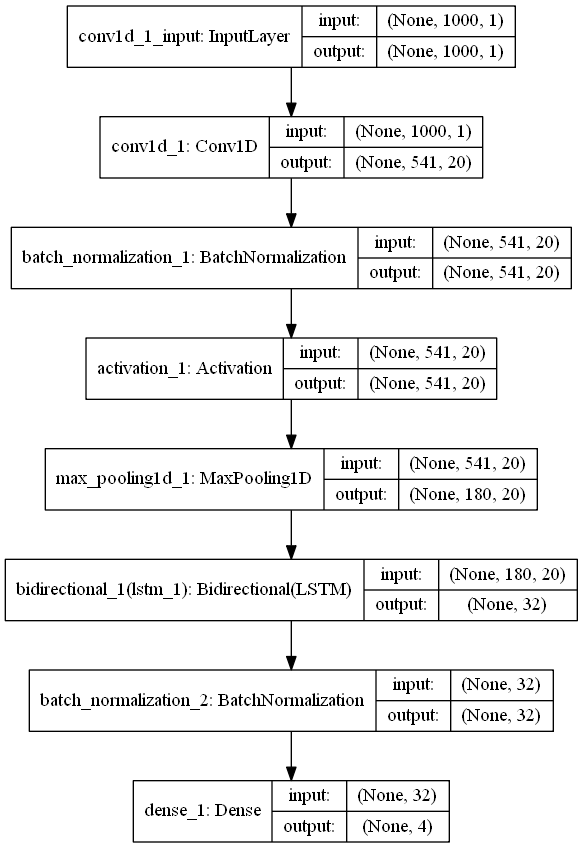

In [15]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

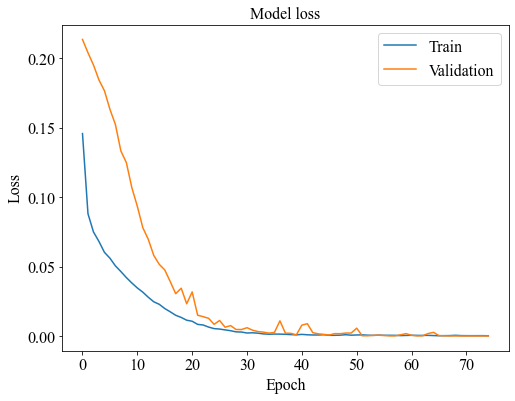

In [16]:
averaged_history_val_loss = np.mean(np.array(all_scores_history[1:]), axis=0)
averaged_history_train_loss = np.mean(np.array(train_loss_history_list[1:]), axis=0)
font_size = 16
# plot loss on training set and validation set 
plt.figure(figsize=(8, 6))
plt.plot(averaged_history_train_loss)
plt.plot(averaged_history_val_loss)
plt.title('Model loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.ylabel('Loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.xlabel('Epoch', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.legend(['Train', 'Validation'], loc='upper right', prop={'family':'Times New Roman', 'size':font_size})
plt.xticks(fontproperties = 'Times New Roman', fontsize=font_size)
plt.yticks(fontproperties = 'Times New Roman', fontsize=font_size)
#plt.savefig('loss.eps',dpi=300, bbox_inches="tight")
plt.show()

In [17]:
del model

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

In [21]:
def confusion_matrix(pres, y_test):
    cm = np.zeros((8,8))
    for id, pre in enumerate(pres):
        column = int(pre[0]*4 + pre[1] * 2 + pre[2] * 1 )
        row = int(y_test[id, 0]*4 + y_test[id, 1] * 2 + y_test[id, 2] * 1)
        cm[row, column] += 1
    return cm

def heatmap(ma, filename):
    labels = ["000", "001","010","011","100","101","110","111"]
    acc = np.round(np.sum(np.diag(ma))/np.sum(ma), 5)
    ma = pd.DataFrame(ma, index=labels, columns=labels)
    f,ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(ma, annot=True, center=11, cmap='RdYlBu')
    plt.xlabel("Predicted labels",fontdict={'size':16})
    plt.ylabel("Target labels",fontdict={'size':16})
    plt.title('Accuracy = %s %%'%str(acc*100))
    #plt.savefig('%s.eps'%str(filename),dpi=300, bbox_inches="tight")
    plt.show()

In [20]:
from keras.models import load_model

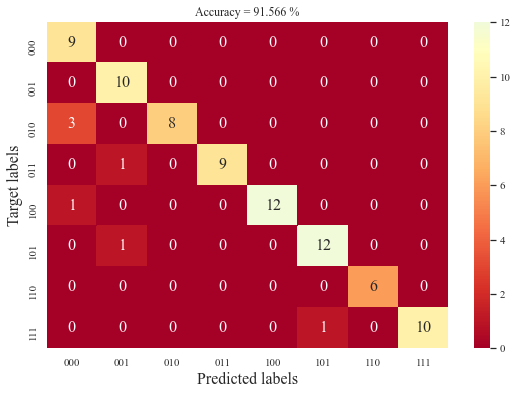

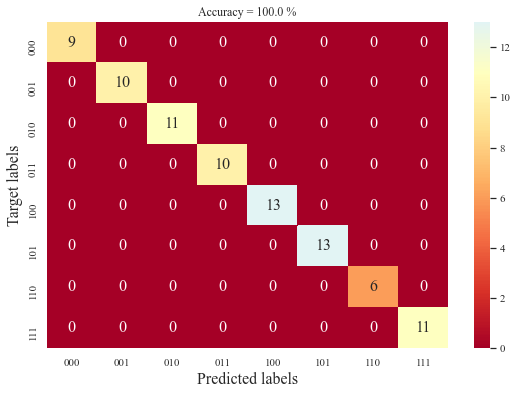

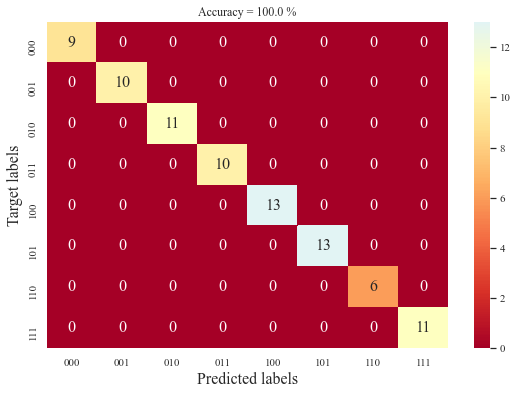

In [23]:
# The model_names may be different, please check the data/4_bins/weights/ folder
models_names = ['weights-improvement-01-0.17.hdf5', 'weights-improvement-17-0.02.hdf5', 'weights-improvement-30-0.01.hdf5']
for id, name in  enumerate(models_names):
    model = load_model(name)
    pre = model.predict(X_test)
    cm = confusion_matrix(np.around(pre), y_test)
    heatmap(cm, id)

# 20 bins

## Deep learning

In [1]:
%cd ../data/20_bins/20bins

C:\Users\liuzo\01 机器学习 物理\github\data\20_bins\20bins


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

In [3]:
max_min = lambda x: (x-x.min())/(x.max()-x.min())
cwd = os.getcwd()
def prepare_data():    
    X = []
    Y = []
    for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):        
        path = os.path.join(cwd, ''.join(i))        
        names = os.listdir(path)       
        
        for name in names:            
            X.append(pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
            Y.append(np.array(eval('[' + ','.join(i) + ']')))            
        
    return np.array(X), np.array(Y)

In [4]:
X, Y = prepare_data()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326, 1000, 1), (82, 1000, 1), (326, 3), (82, 3))

In [6]:
X_train_d = np.zeros((X_train.shape[0]*2, X_train.shape[1],  X_train.shape[2]))
y_train_d = np.zeros((y_train.shape[0]*2, y_train.shape[1]))

for id  in range(X_train.shape[0]):
    X_train_d[id] = X_train[id]
    y_train_d[id] = y_train[id]
    X_train_d[id + X_train.shape[0]] = max_min(X_train[id] + np.random.normal(loc=0, scale=0.1, size = (X_train.shape[1], X_train.shape[2])))
    y_train_d[id + X_train.shape[0]] = y_train[id]

X_train = X_train_d
y_train = y_train_d
del X_train_d
del y_train_d

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((652, 1000, 1), (82, 1000, 1), (652, 3), (82, 3))

In [8]:
from keras import models
from keras import layers
from keras.optimizers import RMSprop
import numpy as np
seed = 7
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

Using TensorFlow backend.


In [9]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [10]:
def bulid_model_CNN():  
    
    model_list = []   
    
    cnn_out_1 = 20 #16
    cnn_len_1 = 460 #20
    
    model_list.append(
            layers.Conv1D(cnn_out_1, cnn_len_1, input_shape=(X_train.shape[1],1)),
            ) 
    model_list.append(layers.BatchNormalization())
    model_list.append(layers.Activation('relu'))
    model_list.append(layers.MaxPooling1D(3))      
    
    rnn_out = 16  
    lr_rate = 1e-3
    
    
    model_list.append(layers.Bidirectional(layers.LSTM(units=rnn_out, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model_list.append(layers.BatchNormalization())
    
    model_list.append(layers.Dense(y_train.shape[1], activation='sigmoid'))
    model = models.Sequential(model_list)   
    
    
    opt = RMSprop(lr=lr_rate)
    model.compile(optimizer=opt, loss='mse')
   
    return model

In [11]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [12]:
%cd ../weights

C:\Users\liuzo\01 机器学习 物理\github\data\20_bins\weights


In [13]:
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

callbacks_list = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
                   ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')  ]

In [14]:
k = 4
num_val_samples = X_train.shape[0] //k
num_epochs = 75
all_scores = []
all_scores_history = []
train_loss_history_list = []

for i in range(k):
    print('processing fold #', i)
    K.clear_session()  # memory clean 
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)              
    model = bulid_model_CNN()

    history = model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=64, verbose=0, validation_data=(val_data, val_targets),
                        callbacks=callbacks_list)
        
    # Evaluate the model on the validation data
    mae_history = history.history['val_loss']
    train_loss_history = history.history['loss']    

    all_scores_history.append(mae_history)
    train_loss_history_list.append(train_loss_history)    

processing fold # 0

Epoch 00001: saving model to weights-improvement-01-0.24.hdf5

Epoch 00002: saving model to weights-improvement-02-0.24.hdf5

Epoch 00003: saving model to weights-improvement-03-0.24.hdf5

Epoch 00004: saving model to weights-improvement-04-0.23.hdf5

Epoch 00005: saving model to weights-improvement-05-0.22.hdf5

Epoch 00006: saving model to weights-improvement-06-0.23.hdf5

Epoch 00007: saving model to weights-improvement-07-0.22.hdf5

Epoch 00008: saving model to weights-improvement-08-0.21.hdf5

Epoch 00009: saving model to weights-improvement-09-0.18.hdf5

Epoch 00010: saving model to weights-improvement-10-0.20.hdf5

Epoch 00011: saving model to weights-improvement-11-0.17.hdf5

Epoch 00012: saving model to weights-improvement-12-0.20.hdf5

Epoch 00013: saving model to weights-improvement-13-0.13.hdf5

Epoch 00014: saving model to weights-improvement-14-0.17.hdf5

Epoch 00015: saving model to weights-improvement-15-0.17.hdf5

Epoch 00016: saving model to weigh


Epoch 00056: saving model to weights-improvement-56-0.00.hdf5

Epoch 00057: saving model to weights-improvement-57-0.00.hdf5

Epoch 00058: saving model to weights-improvement-58-0.00.hdf5

Epoch 00059: saving model to weights-improvement-59-0.00.hdf5

Epoch 00060: saving model to weights-improvement-60-0.00.hdf5

Epoch 00061: saving model to weights-improvement-61-0.00.hdf5

Epoch 00062: saving model to weights-improvement-62-0.00.hdf5

Epoch 00063: saving model to weights-improvement-63-0.00.hdf5

Epoch 00064: saving model to weights-improvement-64-0.00.hdf5

Epoch 00065: saving model to weights-improvement-65-0.00.hdf5

Epoch 00066: saving model to weights-improvement-66-0.00.hdf5

Epoch 00067: saving model to weights-improvement-67-0.00.hdf5

Epoch 00068: saving model to weights-improvement-68-0.00.hdf5

Epoch 00069: saving model to weights-improvement-69-0.00.hdf5

Epoch 00070: saving model to weights-improvement-70-0.00.hdf5

Epoch 00071: saving model to weights-improvement-71-0.


Epoch 00036: saving model to weights-improvement-36-0.41.hdf5

Epoch 00037: saving model to weights-improvement-37-0.29.hdf5

Epoch 00038: saving model to weights-improvement-38-0.17.hdf5

Epoch 00039: saving model to weights-improvement-39-0.02.hdf5

Epoch 00040: saving model to weights-improvement-40-0.05.hdf5

Epoch 00041: saving model to weights-improvement-41-0.02.hdf5

Epoch 00042: saving model to weights-improvement-42-0.04.hdf5

Epoch 00043: saving model to weights-improvement-43-0.19.hdf5

Epoch 00044: saving model to weights-improvement-44-0.14.hdf5

Epoch 00045: saving model to weights-improvement-45-0.24.hdf5

Epoch 00046: saving model to weights-improvement-46-0.26.hdf5

Epoch 00047: saving model to weights-improvement-47-0.18.hdf5

Epoch 00048: saving model to weights-improvement-48-0.24.hdf5

Epoch 00049: saving model to weights-improvement-49-0.21.hdf5

Epoch 00050: saving model to weights-improvement-50-0.23.hdf5

Epoch 00051: saving model to weights-improvement-51-0.

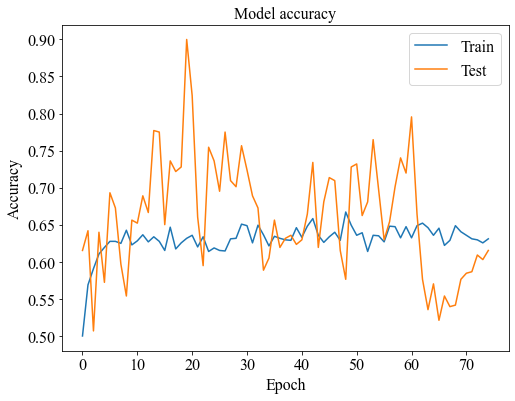

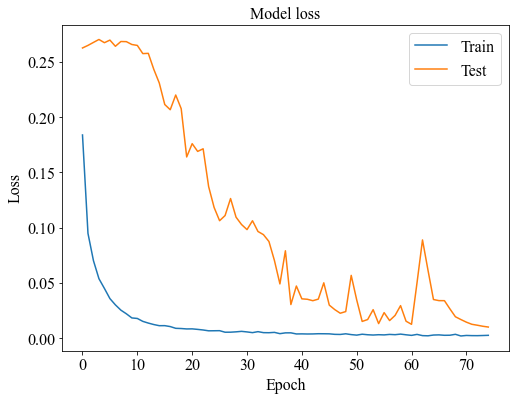

In [15]:
averaged_history_val_loss = np.mean(np.array(all_scores_history[1:]), axis=0)
averaged_history_train_loss = np.mean(np.array(train_loss_history_list[1:]), axis=0)
font_size = 16

# plot loss on training set and validation set 
plt.figure(figsize=(8, 6))
plt.plot(averaged_history_train_loss)
plt.plot(averaged_history_val_loss)
plt.title('Model loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.ylabel('Loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.xlabel('Epoch', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.legend(['Train', 'Test'], loc='upper right', prop={'family':'Times New Roman', 'size':font_size})
plt.xticks(fontproperties = 'Times New Roman', fontsize=font_size)
plt.yticks(fontproperties = 'Times New Roman', fontsize=font_size)
#plt.savefig('loss.eps',dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

In [17]:
def confusion_matrix(pres, y_test):
    cm = np.zeros((8,8))
    for id, pre in enumerate(pres):
        column = int(pre[0]*4 + pre[1] * 2 + pre[2] * 1 )
        row = int(y_test[id, 0]*4 + y_test[id, 1] * 2 + y_test[id, 2] * 1)
        cm[row, column] += 1
    return cm

def heatmap(ma, filename):
    labels = ["000", "001","010","011","100","101","110","111"]
    acc = np.round(np.sum(np.diag(ma))/np.sum(ma), 5)
    ma = pd.DataFrame(ma, index=labels, columns=labels)
    f,ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(ma, annot=True, center=11, cmap='RdYlBu')
    plt.xlabel("Predicted labels",fontdict={'size':16})
    plt.ylabel("Target labels",fontdict={'size':16})
    plt.title('Accuracy = %s %%'%str(acc*100))
    plt.savefig('%s.eps'%str(filename),dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
from keras.models import load_model

In [19]:
del model

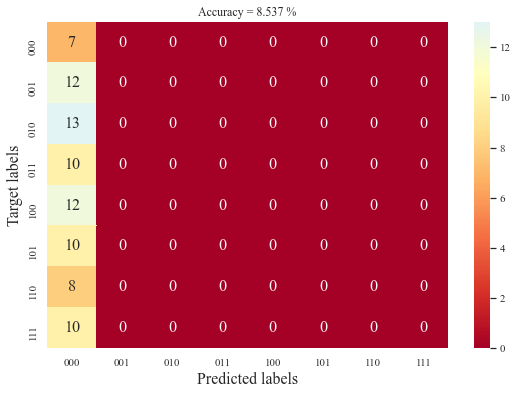

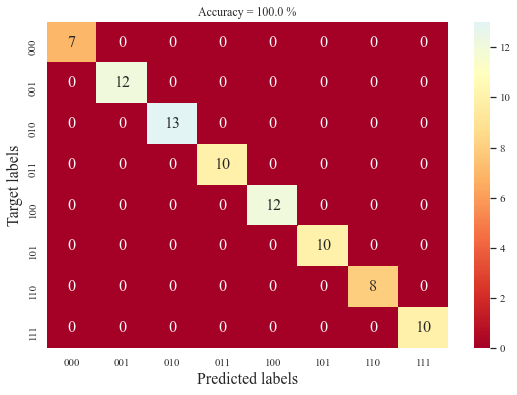

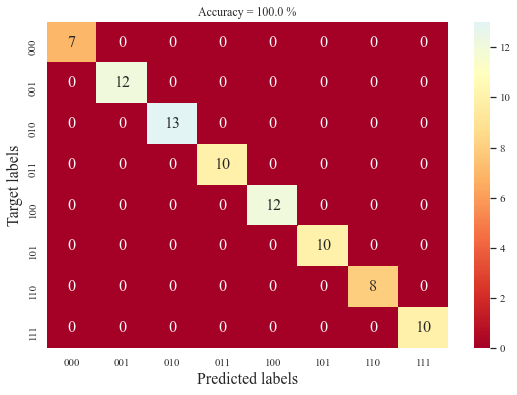

In [21]:
models_names = ['weights-improvement-01-0.25.hdf5','weights-improvement-58-0.03.hdf5','weights-improvement-64-0.02.hdf5']
for id, name in  enumerate(models_names):
    model = load_model(name)
    pre = model.predict(X_test)
    cm = confusion_matrix(np.around(pre), y_test)
    heatmap(cm, id)

## Master equation

In [13]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

In [14]:
def heatmap(ma, filename):
    labels = ["000", "001","010","011","100","101","110","111"]
    acc = np.round(np.sum(np.diag(ma))/np.sum(ma), 5)
    ma = pd.DataFrame(ma, index=labels, columns=labels)
    f,ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(ma, annot=True, center=11, cmap='RdYlBu')
    plt.xlabel("Predicted labels",fontdict={'size':16})
    plt.ylabel("Target labels",fontdict={'size':16})
    plt.title('Accuracy = %s %%'%str(acc*100))
    plt.savefig('%s.eps'%str(filename),dpi=300, bbox_inches="tight")
    plt.show()

The data below come from the results of Mathematica notebook "/notebook/Fig5/20bins_fitting.nb"

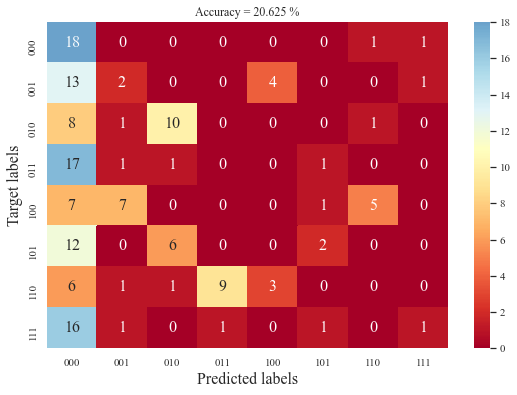

In [20]:
cm_master=np.concatenate([np.histogram([0,0,0,0,0,0,0,6,0,0,0,0,0,0,7,0,0,0,0,0],bins=np.arange(9))[0],
np.histogram([0,0,0,1,4,4,4,0,0,0,0,1,4,0,0,0,0,0,0,7],bins=np.arange(9))[0],
np.histogram([0,0,6,2,2,0,2,0,2,0,2,1,0,2,2,2,0,2,0,2],bins=np.arange(9))[0],
np.histogram([0,0,0,0,1,0,0,5,2,0,0,0,0,0,0,0,0,0,0,0],bins=np.arange(9))[0],
np.histogram([1,6,6,0,6,1,1,1,0,1,1,6,1,0,0,0,6,0,5,0],bins=np.arange(9))[0],
np.histogram([0,0,0,0,5,5,2,0,0,0,0,0,2,0,0,2,2,2,0,2],bins=np.arange(9))[0],
np.histogram([3,0,3,3,0,3,3,4,1,4,3,0,2,3,4,0,0,0,3,3],bins=np.arange(9))[0],
np.histogram([0,0,0,0,7,0,0,0,3,0,5,0,0,0,0,0,0,0,1,0],bins=np.arange(9))[0]],axis=0).reshape(8,8)
heatmap(cm_master,'20bins')

# 200 Hz

## Deep learning

In [1]:
%cd ../data/resolution/resolution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

In [3]:
max_min = lambda x: (x-x.min())/(x.max()-x.min())
cwd = os.getcwd()

def prepare_data():    
    X = []
    Y = []
    for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):        
        path = os.path.join(cwd, ''.join(i))        
        names = os.listdir(path)       
        
        for name in names:            
            X.append(pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
            Y.append(np.array(eval('[' + ','.join(i) + ']')))            
        
    return np.array(X), np.array(Y)

In [4]:
X, Y = prepare_data()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((390, 1000, 1), (98, 1000, 1), (390, 3), (98, 3))

In [6]:
X_train_d = np.zeros((X_train.shape[0]*2, X_train.shape[1],  X_train.shape[2]))
y_train_d = np.zeros((y_train.shape[0]*2, y_train.shape[1]))

for id  in range(X_train.shape[0]):
    X_train_d[id] = X_train[id]
    y_train_d[id] = y_train[id]
    X_train_d[id + X_train.shape[0]] = max_min(X_train[id] + np.random.normal(loc=0, scale=0.5, size = (X_train.shape[1], X_train.shape[2])))
    y_train_d[id + X_train.shape[0]] = y_train[id]

X_train = X_train_d
y_train = y_train_d
del X_train_d
del y_train_d

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((780, 1000, 1), (98, 1000, 1), (780, 3), (98, 3))

In [8]:
from keras import models
from keras import layers
from keras.optimizers import RMSprop
import numpy as np
seed = 7
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

Using TensorFlow backend.


In [9]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [10]:
def bulid_model_CNN():  
    
    model_list = []   
    
    cnn_out_1 = 20 #16
    cnn_len_1 = 460 #20
    
    model_list.append(
            layers.Conv1D(cnn_out_1, cnn_len_1, input_shape=(X_train.shape[1],1)),
            ) 
    model_list.append(layers.BatchNormalization())
    model_list.append(layers.Activation('relu'))
    model_list.append(layers.MaxPooling1D(3))  
        
    rnn_out = 16  
    lr_rate = 1e-3
    
    
    model_list.append(layers.Bidirectional(layers.LSTM(units=rnn_out, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model_list.append(layers.BatchNormalization())
    
    model_list.append(layers.Dense(y_train.shape[1], activation='sigmoid'))
    model = models.Sequential(model_list)   
    
    
    opt = RMSprop(lr=lr_rate)
    model.compile(optimizer=opt, loss='mse')
   
    return model

In [11]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [12]:
%cd ../weights

C:\Users\liuzo\01 机器学习 物理\github\data\resolution\weights


In [13]:
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

callbacks_list = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10), 
                  ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min') ] 

In [14]:
k = 4
num_val_samples = X_train.shape[0] //k
num_epochs = 100
all_scores = []
all_scores_history = []
train_loss_history_list = []

for i in range(k):
    print('processing fold #', i)
    K.clear_session()  # memory clean
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)              
    model = bulid_model_CNN()

    history = model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=64, verbose=0, validation_data=(val_data, val_targets), callbacks=callbacks_list)
        
    # Evaluate the model on the validation data
    mae_history = history.history['val_loss']
    train_loss_history = history.history['loss']    

    all_scores_history.append(mae_history)
    train_loss_history_list.append(train_loss_history)   

processing fold # 0

Epoch 00001: saving model to weights-improvement-01-0.22.hdf5

Epoch 00002: saving model to weights-improvement-02-0.22.hdf5

Epoch 00003: saving model to weights-improvement-03-0.21.hdf5

Epoch 00004: saving model to weights-improvement-04-0.20.hdf5

Epoch 00005: saving model to weights-improvement-05-0.20.hdf5

Epoch 00006: saving model to weights-improvement-06-0.18.hdf5

Epoch 00007: saving model to weights-improvement-07-0.17.hdf5

Epoch 00008: saving model to weights-improvement-08-0.16.hdf5

Epoch 00009: saving model to weights-improvement-09-0.14.hdf5

Epoch 00010: saving model to weights-improvement-10-0.14.hdf5

Epoch 00011: saving model to weights-improvement-11-0.14.hdf5

Epoch 00012: saving model to weights-improvement-12-0.15.hdf5

Epoch 00013: saving model to weights-improvement-13-0.13.hdf5

Epoch 00014: saving model to weights-improvement-14-0.12.hdf5

Epoch 00015: saving model to weights-improvement-15-0.11.hdf5

Epoch 00016: saving model to weigh


Epoch 00031: saving model to weights-improvement-31-0.04.hdf5

Epoch 00032: saving model to weights-improvement-32-0.05.hdf5

Epoch 00033: saving model to weights-improvement-33-0.03.hdf5

Epoch 00034: saving model to weights-improvement-34-0.04.hdf5

Epoch 00035: saving model to weights-improvement-35-0.03.hdf5

Epoch 00036: saving model to weights-improvement-36-0.02.hdf5

Epoch 00037: saving model to weights-improvement-37-0.05.hdf5

Epoch 00038: saving model to weights-improvement-38-0.03.hdf5

Epoch 00039: saving model to weights-improvement-39-0.05.hdf5

Epoch 00040: saving model to weights-improvement-40-0.04.hdf5

Epoch 00041: saving model to weights-improvement-41-0.03.hdf5

Epoch 00042: saving model to weights-improvement-42-0.02.hdf5

Epoch 00043: saving model to weights-improvement-43-0.03.hdf5

Epoch 00044: saving model to weights-improvement-44-0.02.hdf5

Epoch 00045: saving model to weights-improvement-45-0.03.hdf5

Epoch 00046: saving model to weights-improvement-46-0.


Epoch 00061: saving model to weights-improvement-61-0.04.hdf5

Epoch 00062: saving model to weights-improvement-62-0.04.hdf5

Epoch 00063: saving model to weights-improvement-63-0.04.hdf5

Epoch 00064: saving model to weights-improvement-64-0.04.hdf5

Epoch 00065: saving model to weights-improvement-65-0.04.hdf5

Epoch 00066: saving model to weights-improvement-66-0.03.hdf5

Epoch 00067: saving model to weights-improvement-67-0.04.hdf5

Epoch 00068: saving model to weights-improvement-68-0.04.hdf5

Epoch 00069: saving model to weights-improvement-69-0.03.hdf5

Epoch 00070: saving model to weights-improvement-70-0.03.hdf5

Epoch 00071: saving model to weights-improvement-71-0.03.hdf5

Epoch 00072: saving model to weights-improvement-72-0.03.hdf5

Epoch 00073: saving model to weights-improvement-73-0.03.hdf5

Epoch 00074: saving model to weights-improvement-74-0.03.hdf5

Epoch 00075: saving model to weights-improvement-75-0.02.hdf5

Epoch 00076: saving model to weights-improvement-76-0.


Epoch 00091: saving model to weights-improvement-91-0.03.hdf5

Epoch 00092: saving model to weights-improvement-92-0.03.hdf5

Epoch 00093: saving model to weights-improvement-93-0.03.hdf5

Epoch 00094: saving model to weights-improvement-94-0.03.hdf5

Epoch 00095: saving model to weights-improvement-95-0.03.hdf5

Epoch 00096: saving model to weights-improvement-96-0.03.hdf5

Epoch 00097: saving model to weights-improvement-97-0.03.hdf5

Epoch 00098: saving model to weights-improvement-98-0.03.hdf5

Epoch 00099: saving model to weights-improvement-99-0.03.hdf5

Epoch 00100: saving model to weights-improvement-100-0.03.hdf5


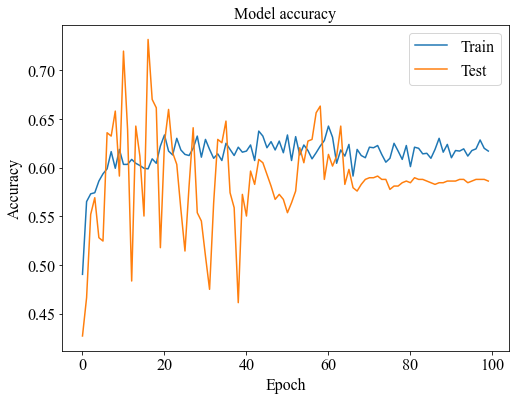

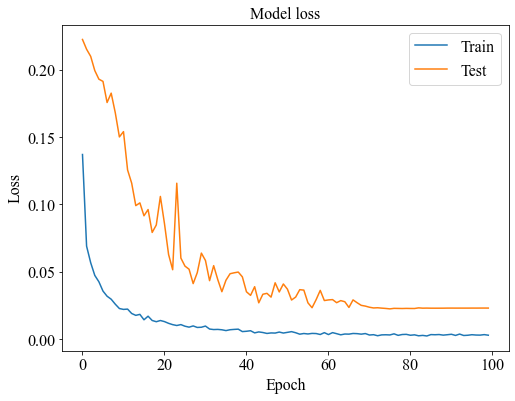

In [15]:
averaged_history_val_loss = np.mean(np.array(all_scores_history[1:]), axis=0)
averaged_history_train_loss = np.mean(np.array(train_loss_history_list[1:]), axis=0)
font_size = 16

# plot loss on training set and validation set 
plt.figure(figsize=(8, 6))
plt.plot(averaged_history_train_loss)
plt.plot(averaged_history_val_loss)
plt.title('Model loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.ylabel('Loss', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.xlabel('Epoch', fontdict={'family' : 'Times New Roman', 'size':font_size})
plt.legend(['Train', 'Test'], loc='upper right', prop={'family':'Times New Roman', 'size':font_size})
plt.xticks(fontproperties = 'Times New Roman', fontsize=font_size)
plt.yticks(fontproperties = 'Times New Roman', fontsize=font_size)
#plt.savefig('loss.eps',dpi=300, bbox_inches="tight")
plt.show()

In [25]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

In [23]:
def confusion_matrix(pres, y_test):
    cm = np.zeros((8,8))
    for id, pre in enumerate(pres):
        column = int(pre[0]*4 + pre[1] * 2 + pre[2] * 1 )
        row = int(y_test[id, 0]*4 + y_test[id, 1] * 2 + y_test[id, 2] * 1)
        cm[row, column] += 1
    return cm

def heatmap(ma, filename):
    labels = ["000", "001","010","011","100","101","110","111"]
    acc = np.round(np.sum(np.diag(ma))/np.sum(ma), 5)
    ma = pd.DataFrame(ma, index=labels, columns=labels)
    f,ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(ma, annot=True, center=11, cmap='RdYlBu')
    plt.xlabel("Predicted labels",fontdict={'size':16})
    plt.ylabel("Target labels",fontdict={'size':16})
    plt.title('Accuracy = %s %%'%str(acc*100))
    #plt.savefig('%s.eps'%str(filename),dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
from keras.models import load_model

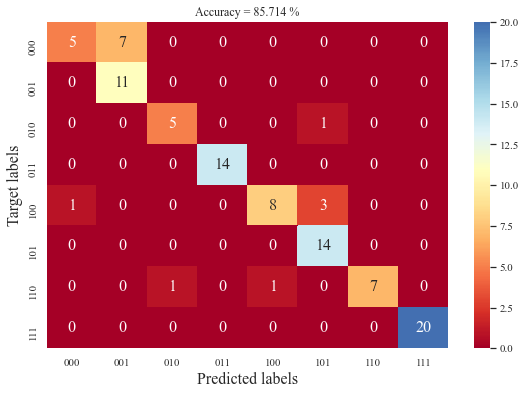

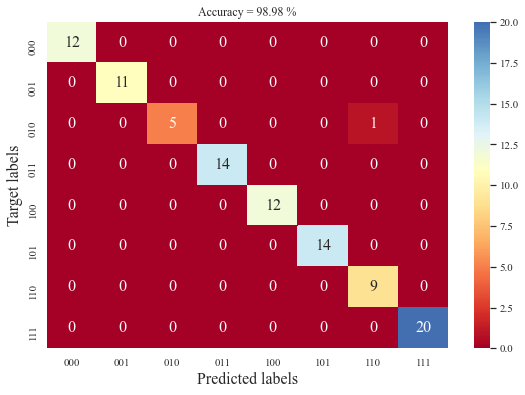

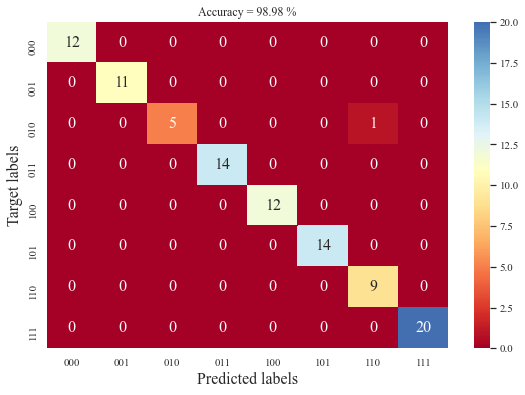

In [20]:
models_names = ['weights-improvement-13-0.11.hdf5', 'weights-improvement-57-0.02.hdf5', 'weights-improvement-100-0.03.hdf5']
for id, name in  enumerate(models_names):
    model = load_model(name)
    pre = model.predict(X_test)
    cm = confusion_matrix(np.around(pre), y_test)
    heatmap(cm, id)

## Mster equation

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

In [17]:
def confusion_matrix(pres, y_test):
    cm = np.zeros((8,8))
    for id, pre in enumerate(pres):
        column = int(pre[0]*4 + pre[1] * 2 + pre[2] * 1 )
        row = int(y_test[id, 0]*4 + y_test[id, 1] * 2 + y_test[id, 2] * 1)
        cm[row, column] += 1
    return cm

def heatmap(ma, filename):
    labels = ["000", "001","010","011","100","101","110","111"]
    acc = np.round(np.sum(np.diag(ma))/np.sum(ma), 5)
    ma = pd.DataFrame(ma, index=labels, columns=labels)
    f,ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(ma, annot=True, center=11, cmap='RdYlBu')
    plt.xlabel("Predicted labels",fontdict={'size':16})
    plt.ylabel("Target labels",fontdict={'size':16})
    plt.title('Accuracy = %s %%'%str(acc*100))
    plt.savefig('%s.eps'%str(filename),dpi=300, bbox_inches="tight")
    plt.show()

The data below come from the results of Mathematica notebook "/notebook/Fig5/200MHz_fitting.nb"

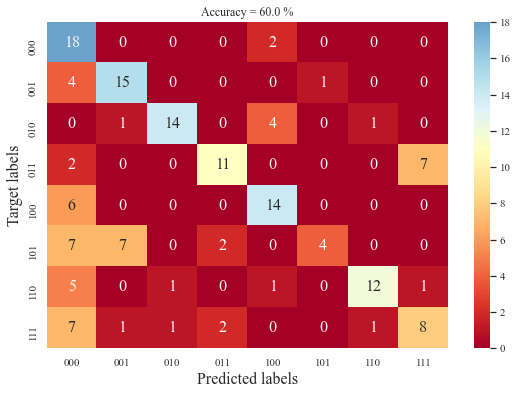

In [21]:
cm_master=np.concatenate([np.histogram([0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],bins=np.arange(9))[0],
np.histogram([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 5, 1, 1, 1, 1],bins=np.arange(9))[0],
np.histogram([6, 2, 2, 2, 2, 2, 1, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2],bins=np.arange(9))[0],
np.histogram([7, 7, 3, 7, 7, 0, 3, 7, 0, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 3],bins=np.arange(9))[0],
np.histogram([0, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4],bins=np.arange(9))[0],
np.histogram([0, 5, 5, 1, 1, 0, 1, 1, 1, 1, 5, 3, 0, 0, 0, 0, 3, 1, 0, 5],bins=np.arange(9))[0],
np.histogram([6, 6, 0, 0, 6, 6, 0, 6, 0, 6, 4, 6, 2, 6, 6, 6, 0, 6, 6, 7],bins=np.arange(9))[0],
np.histogram([3, 7, 0, 7, 7, 0, 6, 7, 7, 3, 0, 0, 0, 0, 7, 2, 7, 1, 7, 0],bins=np.arange(9))[0]],axis=0).reshape(8,8)
heatmap(cm_master,'200Hz')

In [23]:
pwd

'C:\\Users\\liuzo\\01 机器学习 物理\\github\\data\\20_bins\\20bins'

# Data for additional noise

The code in this section is to prepare the data for the master equation. Usually you donnot have to run these since these data already exist.

## 4 bins

In [1]:
%cd ..\data\additional_noise\4bins

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import os
import numpy as np
seed = 7
np.random.seed(seed)
scale_list = np.arange(0.05, 5.5, 0.1)

In [3]:
X = []
Y = []
cwd = os.getcwd()

max_min = lambda x: (x-x.min())/(x.max()-x.min())
#np.set_printoptions(precision=3)

for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)],str(0))):        
    path = os.path.join(cwd, ''.join(i))        
    names = os.listdir(path)       

    for name in names: 
        t = pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[0]).to_numpy()
        X = (pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
        Y.append(np.array(eval('[' + ','.join(i) + ']')))   
        
        for scale in scale_list:
            X_new = np.zeros_like(X)
            X_new = (X + np.random.normal(loc=0, scale=scale, size = X.shape))
            #np.savetxt(str(name)[:-4]+str(scale)+'.txt', np.c_[t ,X_new] ,delimiter='\t', fmt='%.4e')
            
            try:
                os.mkdir(''.join(i)+'/'+"{0:.2f}".format(scale))

            except FileExistsError:
                pass
            
            np.savetxt(''.join(i)+'/'+"{0:.2f}".format(scale)+'/'+str(name)[:-4]+'.txt', np.c_[t ,max_min(X_new)] ,delimiter='\t', fmt='%.4e')

In [ ]:
import shutil

cwd = os.getcwd()
for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):   
    path = os.path.join(cwd, ''.join(i))  
    for scale in scale_list:
        path1 = os.path.join(path, "{0:.2f}".format(scale))
        try:
            shutil.rmtree(path1)
        except (FileNotFoundError, PermissionError) as e:
            print("Error: %s : %s" % (path1, e.strerror))

In [ ]:
max_min = lambda x: (x-x.min())/(x.max()-x.min())
data = (pd.read_csv('000\\02.txt' , sep='\t',  usecols=[2]).apply(max_min).to_numpy()) 
plt.figure(figsize=(26, 6))
scale_list_plot = np.linspace(0, 1, 8)
for id, scale in enumerate(scale_list_plot):
    data1 = data +  np.random.normal(loc=0, scale=scale, size = data.shape)
    plt.subplot(2,4, id+1)
    plt.plot(max_min(data1))
    plt.title('scale = '+str(scale))

plt.show()

## 20 bins

In [1]:
%cd ..\data\additional_noise\20bins

C:\Users\liuzo\01 机器学习 物理\github\data\additional_noise\20bins


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import os
import numpy as np
seed = 7
np.random.seed(seed)
scale_list = np.arange(0.05, 5.5, 0.1)

In [8]:
X = []
Y = []
cwd = os.getcwd()

max_min = lambda x: (x-x.min())/(x.max()-x.min())
#np.set_printoptions(precision=3)

for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):        
    path = os.path.join(cwd, ''.join(i))        
    names = os.listdir(path)       

    for name in names: 
        t = pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[0]).to_numpy()
        X = (pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
        Y.append(np.array(eval('[' + ','.join(i) + ']')))   
        
        for scale in scale_list:
            X_new = np.zeros_like(X)
            X_new = (X + np.random.normal(loc=0, scale=scale, size = X.shape))
            #np.savetxt(str(name)[:-4]+str(scale)+'.txt', np.c_[t ,X_new] ,delimiter='\t', fmt='%.4e')
            
            try:
                os.mkdir(''.join(i)+'/'+"{0:.2f}".format(scale))

            except FileExistsError:
                pass
            
            np.savetxt(''.join(i)+'/'+"{0:.2f}".format(scale)+'/'+str(name)[:-4]+'.txt', np.c_[t ,max_min(X_new)] ,delimiter='\t', fmt='%.4e')

In [6]:
import shutil

cwd = os.getcwd()
for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):   
    path = os.path.join(cwd, ''.join(i))  
    for scale in scale_list:
        path1 = os.path.join(path, "{0:.2f}".format(scale))
        try:
            shutil.rmtree(path1)
        except (FileNotFoundError, PermissionError) as e:
            print("Error: %s : %s" % (path1, e.strerror))

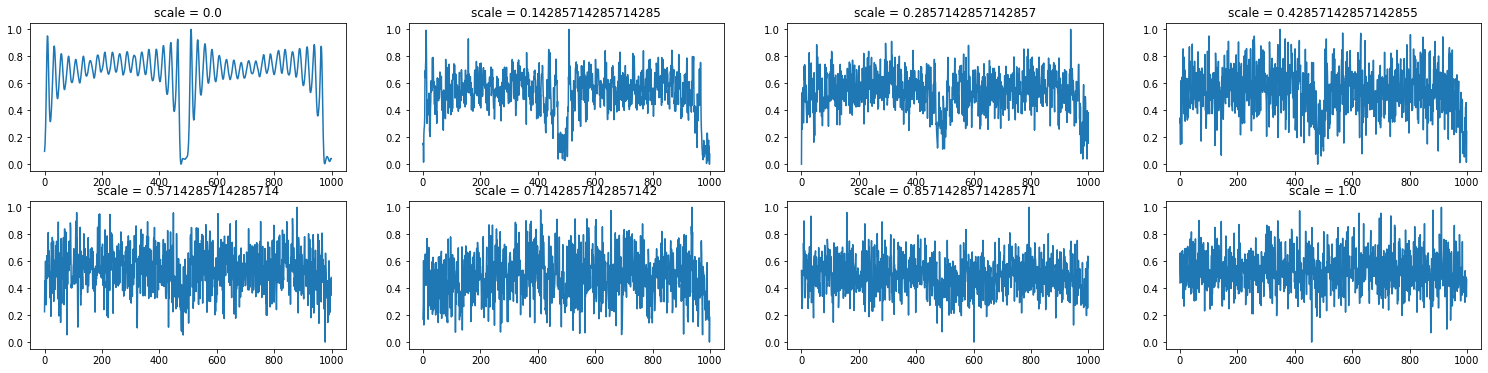

In [9]:
max_min = lambda x: (x-x.min())/(x.max()-x.min())
data = (pd.read_csv('000\\02.txt' , sep='\t',  usecols=[2]).apply(max_min).to_numpy()) 
plt.figure(figsize=(26, 6))
scale_list_plot = np.linspace(0, 1, 8)
for id, scale in enumerate(scale_list_plot):
    data1 = data +  np.random.normal(loc=0, scale=scale, size = data.shape)
    plt.subplot(2,4, id+1)
    plt.plot(max_min(data1))
    plt.title('scale = '+str(scale))

plt.show()

# Additional Noises for 4 bins

In [1]:
%cd ../data/4_bins/4bins

C:\Users\liuzo\01 机器学习 物理\github\data\additional_noise\additional_noise


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 24
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

from keras import models
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
callbacks_list = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)] 
from keras import backend as K

# Some memory clean-up
K.clear_session()

seed = 7
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

Using TensorFlow backend.


In [3]:
train_scale_list = np.arange(0.0, 3.5, 0.1) # The standard deviation of white noise in the training set
model_list = []
max_min = lambda x: (x-x.min())/(x.max()-x.min())
cwd = os.getcwd()

def prepare_data():    
    X = []
    Y = []
    for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)],[str(0)])):        
        path = os.path.join(cwd, ''.join(i))        
        names = os.listdir(path)       
        
        for name in names:            
            X.append(pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
            Y.append(np.array(eval('[' + ','.join(i) + ']')))            
        
    return np.array(X), np.array(Y)[:,:3]

def bulid_model_CNN():  
    
    model_list = []   
    
    cnn_out_1 = 20 #16
    cnn_len_1 = 460 #20
    
    model_list.append(
            layers.Conv1D(cnn_out_1, cnn_len_1, input_shape=(X_train.shape[1],1)),
            ) 
    model_list.append(layers.BatchNormalization())
    model_list.append(layers.Activation('relu'))
    model_list.append(layers.MaxPooling1D(3))     
    
    rnn_out = 16  
    lr_rate = 1e-3
    
    
    model_list.append(layers.Bidirectional(layers.LSTM(units=rnn_out, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model_list.append(layers.BatchNormalization())
    
    model_list.append(layers.Dense(y_train.shape[1], activation='sigmoid'))
    model = models.Sequential(model_list)   
    
    
    opt = RMSprop(lr=lr_rate)
    model.compile(optimizer=opt, loss='mse')
   
    return model

In [4]:
for scale in train_scale_list:
    
    X, Y = prepare_data()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=7)

    X_train_d = np.zeros((X_train.shape[0]*2, X_train.shape[1],  X_train.shape[2]))
    y_train_d = np.zeros((y_train.shape[0]*2, y_train.shape[1]))

    for id  in range(X_train.shape[0]):
        X_train_d[id] = X_train[id]
        y_train_d[id] = y_train[id]
        X_train_d[id + X_train.shape[0]] =(X_train[id] + np.random.normal(loc=0, scale=scale, size = (X_train.shape[1], X_train.shape[2])))
        y_train_d[id + X_train.shape[0]] = y_train[id]

    X_train = X_train_d
    y_train = y_train_d
    del X_train_d
    del y_train_d

    k = 4
    num_val_samples = X_train.shape[0] //k
    num_epochs = 75

    for i in range(k):
        print('processing fold #', i)
        K.clear_session() 
        # Prepare the validation data: data from partition # k
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [X_train[:i * num_val_samples],
             X_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples],
             y_train[(i + 1) * num_val_samples:]],
            axis=0)
                   
        model = bulid_model_CNN()

        history = model.fit(partial_train_data, partial_train_targets,
                  epochs=num_epochs, batch_size=64, verbose=0, validation_data=(val_data, val_targets),
                            callbacks=callbacks_list)

    model.save(str(scale))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
scale_list=np.arange(0.0, 5.5, 0.1) # The standard deviation of white noise in the test set
acc_mat = []
for scale_train in train_scale_list:
    acc_list = np.zeros((5, len(scale_list)))
    reconstructed_model = models.load_model(str(scale_train))
    for ii in range(5):

        for ind, scale in enumerate( scale_list):
            X_test_d = np.zeros((X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
            y_test_d = np.zeros((y_test.shape[0], y_test.shape[1]))

            for id  in range(X_test.shape[0]):
                X_test_d[id] = (X_test[id] + np.random.normal(loc=0, scale=scale, size = (X_test.shape[1], X_test.shape[2])))
                y_test_d[id] = y_test[id] 

            mse, mae = reconstructed_model.evaluate(X_test_d, y_test_d, verbose=0)
            pre = reconstructed_model.predict(X_test_d)
            #display(np.abs(np.around(pre) -y_test))
            accuracy = sum([1 if np.sum(np.abs(np.around(pre[i]) -y_test_d[i])) == 0 else 0 for i in range(len(pre)) ])/len(pre)
            acc_list[ii,ind] = accuracy

    acc_mat.append(np.mean(np.array(acc_list),axis=0)) 

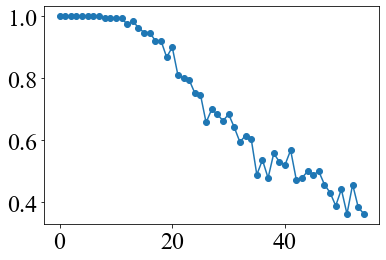

In [9]:
plt.plot(acc_mat[0],'-o')

Data is from master equation fitting, which is "calculated by /notebook/4bins_fitting.nb"

The "acc_mat0" is "acc_mat[0]" calculated above. It can be replaced by "acc_mat[0]".

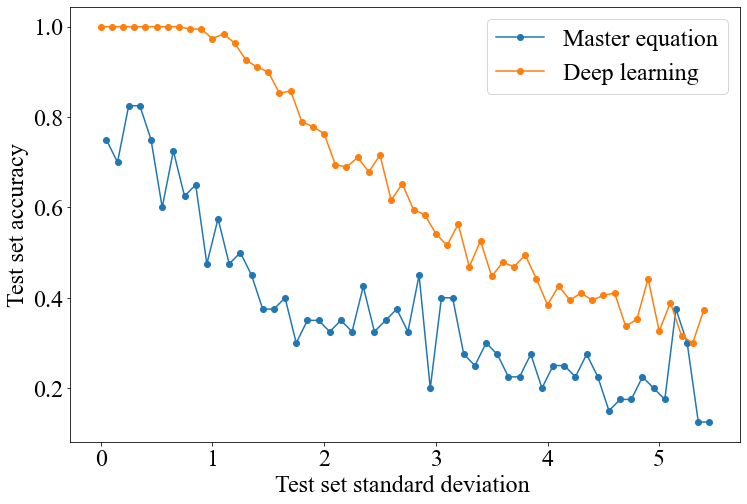

In [15]:
data = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3, 4, 4, 4, \
4, 4, 3, 5, 5, 5, 0, 6, 6, 6, 0, 0, 0, 1, 4, 0, 4, 0, 0, 0, 0, 0, 1, \
1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 7, 5, 7, \
3, 4, 3, 7, 7, 0, 6, 0, 7, 6, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, \
2, 2, 2, 3, 3, 5, 3, 7, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 0, 7, 7, 0, 6, \
7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 3, 3, 3, \
3, 3, 4, 4, 4, 4, 4, 2, 5, 5, 0, 5, 6, 0, 7, 7, 6, 7, 7, 7, 7, 1, 0, \
0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 0, 0, 3, 3, 4, 4, 4, 4, \
4, 5, 2, 6, 0, 5, 6, 0, 0, 3, 0, 7, 7, 7, 7, 5, 0, 0, 0, 0, 0, 1, 1, \
6, 1, 0, 2, 2, 2, 0, 2, 3, 5, 3, 3, 3, 0, 0, 4, 0, 4, 0, 2, 6, 2, 4, \
0, 0, 0, 7, 6, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, \
0, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 0, 0, 6, 1, 0, 1, 0, 0, 0, 7, \
7, 7, 7, 7, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 4, 0, 0, 3, \
3, 0, 4, 4, 4, 4, 0, 2, 0, 7, 2, 0, 0, 2, 0, 0, 7, 7, 7, 7, 7, 0, 0, \
0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 3, 4, 0, 4, 4, 4, \
2, 2, 1, 3, 2, 6, 0, 1, 0, 6, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 1, 1, 1, \
1, 0, 2, 2, 2, 5, 0, 4, 0, 4, 3, 0, 0, 4, 4, 0, 4, 2, 2, 0, 0, 2, 0, \
0, 0, 1, 0, 7, 7, 5, 7, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, \
0, 3, 3, 0, 0, 0, 4, 4, 0, 4, 4, 2, 0, 0, 0, 2, 0, 0, 6, 0, 0, 7, 7, \
0, 4, 0, 4, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 4, 0, 1, 4, \
6, 0, 0, 4, 4, 7, 0, 2, 0, 2, 6, 0, 7, 4, 6, 0, 0, 7, 7, 7, 0, 0, 0, \
0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 4, 0, 0, 3, 4, 4, 4, 0, 4, 0, \
0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 3, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, \
0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 4, 4, 4, 4, 4, 2, 2, 0, 0, 0, 6, 0, \
0, 0, 0, 1, 1, 0, 7, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 2, \
0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 0, 1, 6, 0, 1, 6, \
0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 4, 0, 3, 0, 0, 0, \
0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, \
0, 1, 0, 1, 4, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 0, 2, \
0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 3, 1, 0, \
2, 0, 2, 2, 3, 0, 4, 4, 0, 3, 4, 0, 4, 4, 0, 0, 1, 0, 0, 6, 0, 0, 0, \
3, 1, 5, 5, 2, 2, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 0, \
0, 0, 0, 0, 0, 6, 0, 0, 4, 7, 6, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, \
0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 3, 2, 2, 0, 0, 7, 0, 0, 0, 0, 0, 0, \
0, 0, 4, 0, 2, 0, 0, 0, 6, 0, 1, 0, 6, 0, 1, 6, 2, 0, 0, 4, 0, 4, 0, \
0, 0, 4, 1, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 1, 0, 0, \
0, 0, 0, 1, 0, 0, 6, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, \
0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 4, 4, 4, 2, 6, 0, 0, 0, 6, 1, 6, 0, \
0, 0, 0, 0, 4, 1, 4, 0, 0, 0, 0, 0, 0, 7, 3, 1, 2, 2, 2, 2, 6, 0, 6, \
0, 4, 4, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 4, 0, \
0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 4, 4, 4, \
0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 4, 0, 0, 1, \
0, 1, 1, 0, 0, 2, 2, 5, 3, 0, 0, 0, 4, 0, 4, 0, 4, 0, 4, 3, 5, 0, 0, \
2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 4, 1, 1, 0, 2, 1, 0, 2, \
2, 0, 0, 0, 0, 0, 0, 1, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, \
2, 1, 0, 0, 0, 0, 0, 4, 0, 0, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 3, 0, \
3, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 1, 6, 0, 0, 0, 6, 2, 0, 5, 0, 0, 0, \
0, 0, 0, 0, 1, 0, 1, 4, 0, 6, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 4, 4, 0, \
0, 0, 0, 0, 0, 7, 0, 1, 6, 0, 6, 1, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, \
7, 1, 1, 0, 2, 2, 2, 2, 0, 3, 3, 0, 0, 2, 4, 4, 0, 0, 0, 0, 0, 4, 4, \
6, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, \
5, 0, 0, 0, 2, 5, 6, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, \
0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 6, 0, 0, 0, 0, 0, 3, 0, \
0, 0, 4, 4, 5, 4, 1, 5, 1, 0, 5, 1, 2, 1, 0, 6, 0, 1, 0, 0, 0, 0, 0, \
0, 0, 0, 0, 1, 1, 3, 1, 2, 2, 0, 0, 4, 5, 0, 3, 0, 3, 0, 0, 4, 4, 4, \
5, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 0, 1, \
0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 6, \
0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 0, \
0, 0, 0, 0, 0, 3, 0, 2, 2, 4, 4, 0, 5, 1, 0, 0, 0, 0, 4, 5, 0, 6, 0, \
0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 4, 0, 1, 0, 2, 0, 4, 0, 0, 7, 0, \
0, 4, 4, 4, 4, 0, 0, 1, 1, 0, 0, 0, 0, 6, 6, 0, 0, 4, 0, 6, 0, 0, 0, \
0, 0, 0, 1, 1, 0, 1, 6, 0, 3, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, \
0, 0, 5, 0, 2, 0, 0, 0, 6, 0, 5, 0, 5, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, \
0, 0, 0, 4, 0, 0, 0, 3, 7, 0, 1, 0, 2, 4, 4, 0, 0, 1, 0, 0, 0, 4, 0, \
4, 0, 2, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 1, 1, 0, 2, 0, 0, 0, \
0, 0, 7, 5, 0, 0, 0, 4, 0, 6, 1, 1, 4, 0, 0, 1, 0, 0, 1, 0, 6, 7, 0, \
0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 2, \
0, 4, 0, 0, 0, 0, 3, 0, 0, 2, 1, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, \
0, 1, 0, 7, 0, 1, 6, 4, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, \
0, 1, 0, 0, 0, 6, 1, 0, 0, 4, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, \
6, 2, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 4, 1, 0, 0, 5, 0, 6, 0, 0, \
7, 0, 0, 1, 0, 0, 1, 0, 0, 4, 0, 0, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, \
0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 1, 0, 6, 4, 0, 0, 0, \
0, 0, 0, 0, 6, 0, 1, 0, 1, 0, 0, 2, 3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 6, \
0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 6, 0, 1, 0, 0, 0, 0, 0, \
0, 1, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 5, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, \
0, 0, 4, 0, 0, 6, 0, 0, 2, 0, 0, 0, 4, 3, 0, 4, 0, 0, 0, 1, 1, 1, 2, \
0, 0, 0, 1, 0, 0, 0, 3, 2, 0, 0, 0, 4, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, \
0, 0, 7, 1, 2, 0, 4, 0, 0, 4, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, \
1, 0, 3, 0, 4, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 5, 4, 4, 0, 0, 0, 4, 0, \
2, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 1, 4, 0, \
0, 2, 5, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 1, 0, 0, 0, 0, 4, 4, 0, 0, 0, \
0, 0, 1, 0, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 3, 0, 3, \
0, 0, 2, 0, 4, 2, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 3, 0, 1, 3, 6, 0, 2, \
2, 2, 2, 0, 0, 0, 3, 0, 0, 4, 2, 0, 0, 2, 6, 0, 2, 0, 2, 0, 0, 0, 0, \
0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 4, 0, 1, 0, 2, 0, 0, 0, 3, 0, 4, 0, \
2, 0, 0, 0, 2, 4, 0, 0, 1, 1, 4, 1, 0, 0, 2, 6, 0, 3, 3, 0, 0, 0, 0, \
0, 0, 4, 0, 2, 0, 2, 6, 1, 0, 0, 0, 0, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, \
0, 5, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, \
0, 1, 0, 3, 0, 0, 2, 0, 4, 3, 0, 4, 0, 0, 4, 0, 4, 4, 0, 1, 5, 0, 0, \
2, 0, 6, 0, 6, 1, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 1, 3, 1, 0, 2, 0, 0, \
0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 5, 1, 5, 0, 4, 0, 0, 0, 1, 0, \
3, 0, 0, 0, 6, 0, 0, 4, 0, 0, 3, 0, 2, 0, 4, 0, 0, 6, 3, 2, 0, 3, 0, \
0, 0, 4, 0, 3, 7, 1, 0, 4, 4, 0, 0, 0, 2, 0, 2, 0, 0, 5, 4, 0, 0, 4, \
0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 6, 0, \
0, 0, 0, 0, 1, 4, 0, 0, 3, 2, 0, 0, 0, 4, 3])

acc_mat0 = np.array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99473684, 0.99473684,
       0.97368421, 0.98421053, 0.96315789, 0.92631579, 0.91052632,
       0.9       , 0.85263158, 0.85789474, 0.78947368, 0.77894737,
       0.76315789, 0.69473684, 0.68947368, 0.71052632, 0.67894737,
       0.71578947, 0.61578947, 0.65263158, 0.59473684, 0.58421053,
       0.54210526, 0.51578947, 0.56315789, 0.46842105, 0.52631579,
       0.44736842, 0.47894737, 0.46842105, 0.49473684, 0.44210526,
       0.38421053, 0.42631579, 0.39473684, 0.41052632, 0.39473684,
       0.40526316, 0.41052632, 0.33684211, 0.35263158, 0.44210526,
       0.32631579, 0.38947368, 0.31578947, 0.3       , 0.37368421])

acc_list = np.zeros(len(data)//40)
for j in range(len(data)//40):
    acc = []
    for i in range(8):
        acc.append(len(np.where(data[(40*j+5*i): (40*j+5*i+5)]== i)[0]))
    acc_list[j]=sum(acc)

plt.figure(figsize=(12, 8))
plt.plot(np.arange(0.05, 5.5, 0.1), acc_list/40,'-o', label='Master equation')
plt.plot(np.arange(0, 5.5, 0.1), acc_mat0, '-o', label='Deep learning')
plt.xlabel('Test set standard deviation ')
plt.ylabel('Test set accuracy')
plt.legend()
plt.savefig('testacc.eps',dpi=300, bbox_inches="tight")

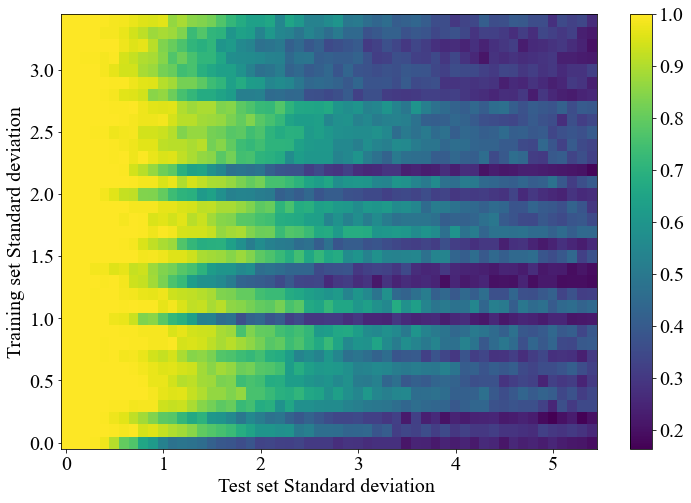

In [7]:
acc_mat = np.squeeze(np.array(acc_mat))

x = np.arange(0, 5.5, 0.1)
y = np.arange(0, 3.5, 0.1)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size":20})
plt.rcParams['font.family'] = 'Times New Roman'
plt.pcolor(X, Y, acc_mat, shading='auto',edgecolors='None',snap=False)
plt.colorbar()
plt.xlabel('Test set standard deviation ')
plt.ylabel('Training set standard deviation')
#plt.savefig('noise_map1.eps')
plt.show()

# Additional noise for 20bins

In [1]:
%cd ..\data\20_bins\20bins

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

from keras import models
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
callbacks_list = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)] 
from keras import backend as K

# Some memory clean-up
K.clear_session()

import numpy as np
seed = 7
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

Using TensorFlow backend.


In [3]:
train_scale_list = np.arange(0.05, 3.5, 0.1)#np.arange(0.0, 3.5, 0.1)
model_list = []
max_min = lambda x: (x-x.min())/(x.max()-x.min())
cwd = os.getcwd()

def prepare_data():    
    X = []
    Y = []
    for i in list(itertools.product([str(0),str(1)], [str(0),str(1)],[str(0),str(1)])):        
        path = os.path.join(cwd, ''.join(i))        
        names = os.listdir(path)       
        
        for name in names:            
            X.append(pd.read_csv(os.path.join(path, name), sep='\t',  usecols=[2]).apply(max_min).to_numpy())            
            Y.append(np.array(eval('[' + ','.join(i) + ']')))            
        
    return np.array(X), np.array(Y)[:,:3]

def bulid_model_CNN():  
    
    model_list = []   
    
    cnn_out_1 = 20 #16
    cnn_len_1 = 460 #20
    
    model_list.append(
            layers.Conv1D(cnn_out_1, cnn_len_1, input_shape=(X_train.shape[1],1)),
            ) 
    model_list.append(layers.BatchNormalization())
    model_list.append(layers.Activation('relu'))
    model_list.append(layers.MaxPooling1D(3))     
    
    rnn_out = 16  
    lr_rate = 1e-3
    
    
    model_list.append(layers.Bidirectional(layers.LSTM(units=rnn_out, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model_list.append(layers.BatchNormalization())
    
    model_list.append(layers.Dense(y_train.shape[1], activation='sigmoid'))
    model = models.Sequential(model_list)   
    
    
    opt = RMSprop(lr=lr_rate)
    model.compile(optimizer=opt, loss='mse')
   
    return model

In [4]:
for scale in train_scale_list:
    
    X, Y = prepare_data()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=7)

    X_train_d = np.zeros((X_train.shape[0]*2, X_train.shape[1],  X_train.shape[2]))
    y_train_d = np.zeros((y_train.shape[0]*2, y_train.shape[1]))

    for id  in range(X_train.shape[0]):
        X_train_d[id] = X_train[id]
        y_train_d[id] = y_train[id]
        X_train_d[id + X_train.shape[0]] = max_min(X_train[id] + np.random.normal(loc=0, scale=scale, size = (X_train.shape[1], X_train.shape[2])))
        y_train_d[id + X_train.shape[0]] = y_train[id]

    X_train = X_train_d
    y_train = y_train_d
    del X_train_d
    del y_train_d

    k = 4
    num_val_samples = X_train.shape[0] //k
    num_epochs = 100

    for i in range(k):
        print('processing fold #', i)
        K.clear_session() 
        # Prepare the validation data: data from partition # k
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [X_train[:i * num_val_samples],
             X_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples],
             y_train[(i + 1) * num_val_samples:]],
            axis=0)
                   
        model = bulid_model_CNN()

        history = model.fit(partial_train_data, partial_train_targets,
                  epochs=num_epochs, batch_size=64, verbose=0, validation_data=(val_data, val_targets),
                            callbacks=callbacks_list)

    model.save(str(scale))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1


In [5]:
scale_list=np.arange(0.0, 5.5, 0.1)
acc_mat = []
for scale_train in train_scale_list:
    acc_list = np.zeros((5, len(scale_list)))
    reconstructed_model = models.load_model(str(scale_train))
    for ii in range(5):

        for ind, scale in enumerate( scale_list):
            X_test_d = np.zeros((X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
            y_test_d = np.zeros((y_test.shape[0], y_test.shape[1]))

            for id  in range(X_test.shape[0]):
                X_test_d[id] = (X_test[id] + np.random.normal(loc=0, scale=scale, size = (X_test.shape[1], X_test.shape[2])))
                y_test_d[id] = y_test[id] 

            mse, mae = reconstructed_model.evaluate(X_test_d, y_test_d, verbose=0)
            pre = reconstructed_model.predict(X_test_d)
            #display(np.abs(np.around(pre) -y_test))
            accuracy = sum([1 if np.sum(np.abs(np.around(pre[i]) -y_test_d[i])) == 0 else 0 for i in range(len(pre)) ])/len(pre)
            acc_list[ii,ind] = accuracy

    acc_mat.append(np.mean(np.array(acc_list),axis=0)) 

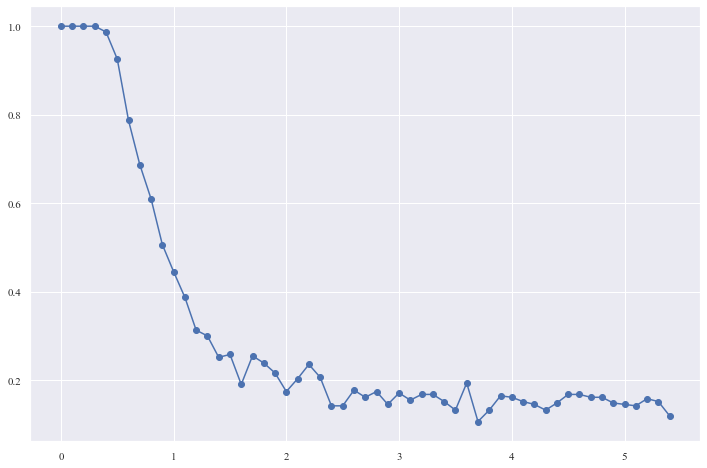

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(scale_list,acc_mat[0],'-o')
plt.show()

In [11]:
acc_mat[0]

array([1.        , 1.        , 1.        , 1.        , 0.98709677,
       0.92580645, 0.78709677, 0.68709677, 0.60967742, 0.50645161,
       0.44516129, 0.38709677, 0.31290323, 0.3       , 0.2516129 ,
       0.25806452, 0.19032258, 0.25483871, 0.23870968, 0.21612903,
       0.17419355, 0.20322581, 0.23548387, 0.20645161, 0.14193548,
       0.14193548, 0.17741935, 0.16129032, 0.17419355, 0.14516129,
       0.17096774, 0.15483871, 0.16774194, 0.16774194, 0.1516129 ,
       0.13225806, 0.19354839, 0.10645161, 0.13225806, 0.16451613,
       0.16129032, 0.1516129 , 0.14516129, 0.13225806, 0.1483871 ,
       0.16774194, 0.16774194, 0.16129032, 0.16129032, 0.1483871 ,
       0.14516129, 0.14193548, 0.15806452, 0.1516129 , 0.11935484])

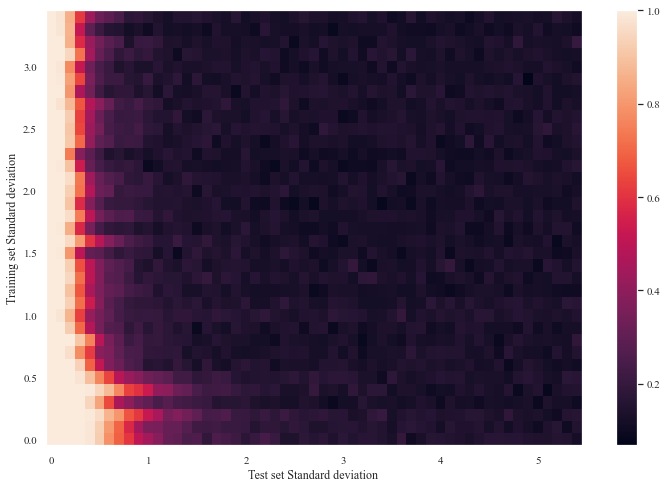

In [12]:
acc_mat = np.squeeze(np.array(acc_mat))

x = np.arange(0, 5.5, 0.1)
y = np.arange(0, 3.5, 0.1)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size":20})
plt.rcParams['font.family'] = 'Times New Roman'
plt.pcolor(X, Y, acc_mat, shading='auto',edgecolors='None',snap=False)
plt.colorbar()
plt.xlabel('Test set standard deviation ')
plt.ylabel('Training set standard deviation')
#plt.savefig('noise_map1.eps')
plt.show()